In [3]:
import pyodbc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import GradientBoostingRegressor

# from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering 1-2-23.csv', delimiter= ";")
df = df[(df["Letra cluster"] == "A") | (df["Letra cluster"] == "B")]
df_10_ag = df[df["Distrito-Nombretipozona"] == '10-Artes graficas']

In [4]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [45]:
# nit_cliente = "'800226417-1'"
# nit_cliente = "'900085929-1'"
nit_cliente = "'900173543-1'"
# nit_cliente = "'800065396-1'"
fecha_final = "'2023-01-31'"

In [46]:
codigo_SQL = f"SELECT DATEFROMPARTS(VTAANO, VTAMES, 1) AS 'Fecha', SUM(VTAVLRVTA) AS 'Ventas' FROM V_VTA_VTAHEC WHERE CONCAT(CONCAT(VTANIT, '-'), VTASUC) = {nit_cliente} AND VTAFCH < {fecha_final} GROUP BY DATEFROMPARTS(VTAANO, VTAMES, 1)"

In [47]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df_SQL = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
df_SQL["Ventas"] = df_SQL["Ventas"].astype(int)
df_SQL["Fecha"] = pd.to_datetime(df_SQL["Fecha"])
df_SQL = df_SQL.set_index("Fecha")

In [10]:
len(df_SQL.values)

61

In [8]:
# Make the data stationary by removing any trends and seasonality
df_diff = df_SQL.diff(periods= 1)
df_diff.dropna(inplace= True)

In [9]:
df_diff.shape

(60, 1)

<Figure size 640x480 with 0 Axes>

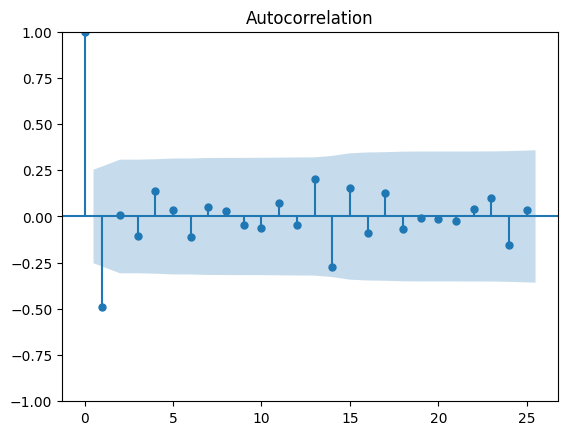

<Figure size 640x480 with 0 Axes>

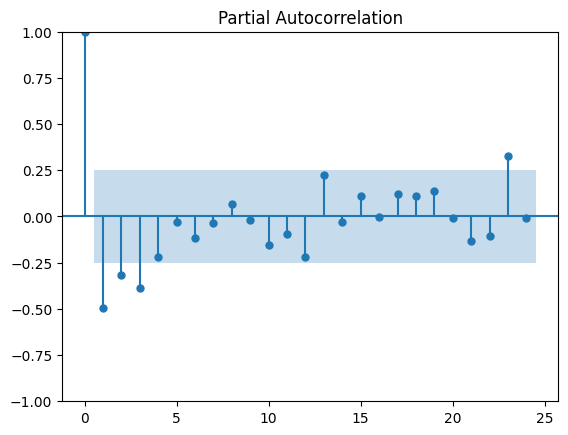

In [10]:
# 2. Model selection

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot the autocorrelation function (ACF) to determine the order of the autoregressive term (
plt.figure()
plot_acf(df_diff, lags=25)
plt.show()

# Plot the partial autocorrelation function (PACF) to determine the order of the moving average term (q)
plt.figure()
plot_pacf(df_diff, lags=24)
plt.show()


In [ ]:
# 2.1 Model selection
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Test the stationarity of the time-series data using the Augmented Dickey-Fuller test
result = adfuller(df_diff["Ventas"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Plot the autocorrelation function (ACF) to determine the order of the autoregressive term (p)
plt.figure()
plot_acf(df_diff, lags=25)
plt.show()

# Plot the partial autocorrelation function (PACF) to determine the order of the moving average term (q)
plt.figure()
plot_pacf(df_diff, lags=25)
plt.show()


In [21]:
# 3. model fitting


# Fit the ARIMA model to the stationary time-series data
model = ARIMA(df_SQL, order=(2,0,3))
model_fit = model.fit()


In [ ]:
# 4. Model evaluation


future_dates = ['2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01']
n_test = 4

# Predict the values using the fitted model
predictions = model_fit.predict(start=len(df_diff), end=len(df_diff)+len(future_dates)-1, typ='levels')

# Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE) and MAPE
mae = mean_absolute_error(df_SQL[-n_test:], predictions)
mse = mean_squared_error(df_SQL[-n_test:], predictions)
mape = mean_absolute_percentage_error(df_SQL[-n_test:], predictions)
print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("MAPE: ", mape)


In [22]:
param_grid = [(p, d, q) for p in range(5) for d in range(2) for q in range(5)]

In [48]:
dict = []

for n, param in enumerate(param_grid):
    try: 
        print(f"Corriendo configuracion: {param_grid[n]}")
        n_train = int(round(df_SQL.shape[0] * 0.8, 0))

        # Split data into training and testing sets
        train = df_SQL[:n_train]
        test = df_SQL[n_train:]

        model = ARIMA(train, order= param_grid[n])
        model_fit = model.fit()
        
        # make predictions
        predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        
        # Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE)
        mae = mean_absolute_error(test, predictions)
        mse = mean_squared_error(test, predictions)
        r2 = r2_score(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)

        dict.append({
                    "param": param_grid[n],
                    "mae": mae,
                    "mse": mse,
                    "r2": r2,
                    "mape": mape
                    })
    except:
        continue

Corriendo configuracion: (0, 0, 0)
Corriendo configuracion: (0, 0, 1)
Corriendo configuracion: (0, 0, 2)
Corriendo configuracion: (0, 0, 3)
Corriendo configuracion: (0, 0, 4)
Corriendo configuracion: (0, 1, 0)
Corriendo configuracion: (0, 1, 1)
Corriendo configuracion: (0, 1, 2)
Corriendo configuracion: (0, 1, 3)
Corriendo configuracion: (0, 1, 4)
Corriendo configuracion: (1, 0, 0)
Corriendo configuracion: (1, 0, 1)
Corriendo configuracion: (1, 0, 2)
Corriendo configuracion: (1, 0, 3)
Corriendo configuracion: (1, 0, 4)
Corriendo configuracion: (1, 1, 0)
Corriendo configuracion: (1, 1, 1)
Corriendo configuracion: (1, 1, 2)
Corriendo configuracion: (1, 1, 3)
Corriendo configuracion: (1, 1, 4)
Corriendo configuracion: (2, 0, 0)
Corriendo configuracion: (2, 0, 1)
Corriendo configuracion: (2, 0, 2)
Corriendo configuracion: (2, 0, 3)
Corriendo configuracion: (2, 0, 4)
Corriendo configuracion: (2, 1, 0)
Corriendo configuracion: (2, 1, 1)
Corriendo configuracion: (2, 1, 2)
Corriendo configurac

In [49]:
results = pd.DataFrame(dict).sort_values('mape')
results.head()

,param,mae,mse,r2,mape
43,"(4, 0, 3)",9.029417e+07,1.288973e+16,-1.062290,1.821650e+22
24,"(2, 0, 4)",9.083839e+07,1.246908e+16,-0.994988,2.090469e+22
33,"(3, 0, 3)",9.049334e+07,1.203449e+16,-0.925455,2.265492e+22
12,"(1, 0, 2)",8.198549e+07,1.045758e+16,-0.673158,2.711362e+22
13,"(1, 0, 3)",8.236466e+07,1.051537e+16,-0.682404,2.711641e+22


In [50]:
model_best = ARIMA(train, order= (4,0,3))
model_fit_best = model_best.fit()

# make predictions
predictions_best = model_fit_best.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [26]:
predictions_best = pd.DataFrame(predictions_best)
predictions_best

,predicted_mean
2022-02-01,1.096053e+08
2022-03-01,9.910518e+07
2022-04-01,1.152460e+08
2022-05-01,1.153108e+08
2022-06-01,1.081391e+08
2022-07-01,1.132822e+08
2022-08-01,1.097223e+08
2022-09-01,1.106189e+08
2022-10-01,1.125229e+08
2022-11-01,1.101641e+08


In [27]:
df_SQL.tail(20)

,Ventas
Fecha,
2021-06-01,98831555
2021-07-01,104823474
2021-08-01,78359249
2021-09-01,92215321
2021-10-01,129391787
2021-11-01,126249856
2021-12-01,131935911
2022-01-01,105096624
2022-02-01,132760928


In [42]:
np.arange(len(df_SQL) - len(test), len(df_SQL))

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [40]:
test

,Ventas
Fecha,
2022-02-01,132760928
2022-03-01,105591364
2022-04-01,106591746
2022-05-01,102274539
2022-06-01,96545991
2022-07-01,105014813
2022-08-01,108509294
2022-09-01,93971376
2022-10-01,131867650


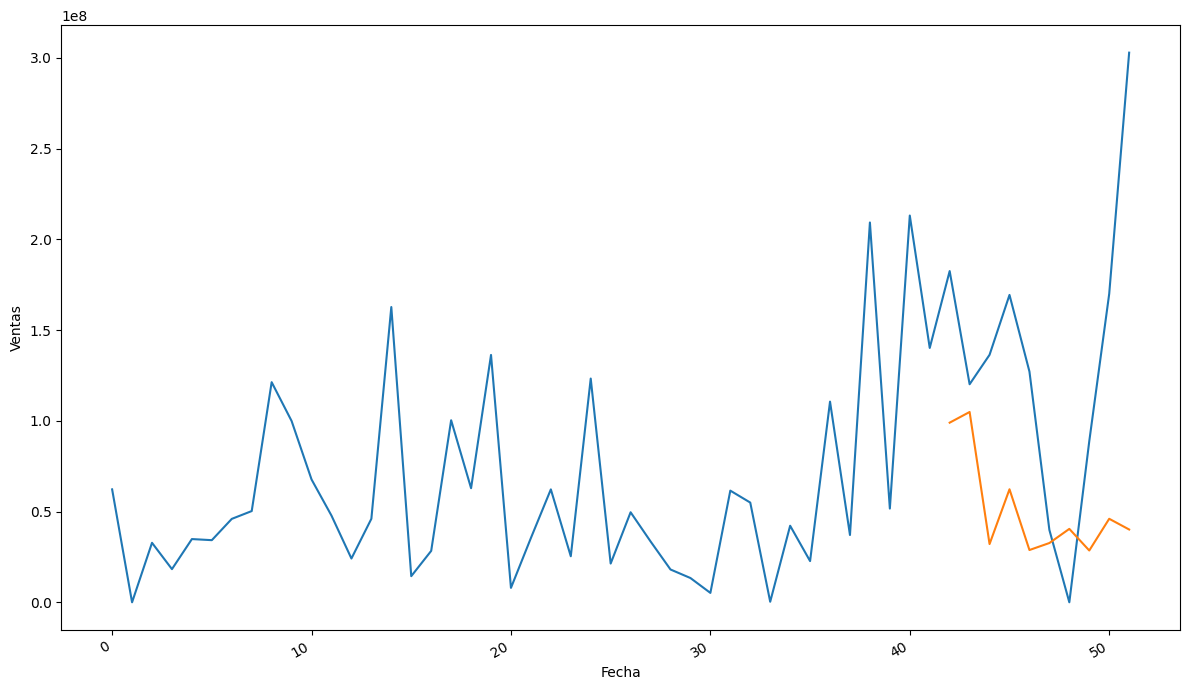

In [51]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_SQL.values)
ax.plot(np.arange(len(df_SQL) - len(test), len(df_SQL)), predictions_best.values)
# ax.plot(predictions_best.values)
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas')
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
results = pd.DataFrame(dict)
results

In [ ]:
dict = []

for n, param in enumerate(param_grid):
    
    n_train = int(round(df_SQL.shape[0] * 0.8, 0))

    # Split data into training and testing sets
    train = df_SQL[:n_train]
    test = df_SQL[n_train:]

    predictions = list()

    model = ARIMA(train, order= param_grid[n])
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE)
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    
    results = dict.append({
                        "param": param_grid[n],
                        "mae": mae,
                        "mse": mse,
                        "mape": mape
                        })


In [ ]:
results = pd.DataFrame(results)
results

In [ ]:
# 5. Model prediction
# Generate predictions for future dates
n_future = 4
future_dates = pd.date_range(df_SQL.index[-1], periods=n_future, freq='D')
future_predictions = model_fit.predict(start=len(df_diff), end=len(df_diff)+len(future_dates)-1, typ='levels')


In [ ]:
future_predictions

In [ ]:
future_predictions

In [ ]:
df_SQL

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
# Load data and perform preprocessing if necessary
df_SQL = df_SQL

n_train = int(round(df_SQL.shape[0] * 0.8, 0))
n_train

# Split data into training and testing sets
train = df_SQL[:n_train]
test = df_SQL[n_train:]

In [ ]:
# Define the performance metric
def evaluate_arima_model(data, arima_order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    mape = mean_absolute_percentage_error(test, predictions)
    return mape

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {'order': [(p, d, q) for p in range(5) for d in range(2) for q in range(5)]}

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order):
        self.order = order
        
    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.model_fit = self.model.fit()
        return self
        
    def predict(self, X):
        return self.model_fit.predict(start=len(X), end=len(X))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y - y_pred) ** 2)

In [ ]:
# Use RandomizedSearchCV to find the best hyperparameters
arima_model = ARIMAWrapper(order=(1,1,1))
# arima = GridSearchCV(arima_model, param_grid, scoring=evaluate_arima_model, cv=5)
arima = RandomizedSearchCV(arima_model, param_grid, scoring=evaluate_arima_model, cv=5)
arima_fit = arima.fit(train)

In [ ]:
# Hacer un grid manual con fors

In [ ]:
# Print the best ARIMA hyperparameters
print("Best ARIMA(p,d,q) = {} with MSE of {}".format(arima_fit.best_params_['order'], arima_fit.best_score_))

In [ ]:
arima_fit.cv_results_

In [52]:
## Normalizacion y denormalizacion
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_data(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))
    return df_scaled, scaler

def revert_normalized_data(df_scaled, scaler):
    df = scaler.inverse_transform(df_scaled)
    return df

